In [1]:
## For data handling
import pandas as pd
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm.notebook import tqdm

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style
set_style("whitegrid")

In [2]:
# Import our data
#data = pd.read_parquet("./combined_data_with_embeddings.parquet")
data = pd.read_parquet("../raw data/combined_data_with_embeddings.parquet")

In [3]:
data

,Text,Label,Original dataset,Row in original dataset,embedding
0,The idea of graduating high school in three ye...,Machine,essays,26613,"[0.01476596, -0.013095475, 0.002932728, -0.011..."
1,"Hey, I'm so excited to write this essay about ...",Machine,essays,26326,"[0.00292786, -0.013083563, 0.0047025573, -0.00..."
2,Introduction\n\nSelf-reliance is a concept tha...,Machine,essays,30579,"[-0.015756093, -0.023221416, -0.010959062, -0...."
3,"Sure, here's my attempt at writing an essay as...",Machine,essays,33547,"[0.013002162, 0.011017485, -0.03551094, 0.0290..."
4,The legalization of marijuana is a highly deba...,Machine,essays,33768,"[0.0016188276, 0.011155421, -0.004596148, 0.00..."
...,...,...,...,...,...
79995,The 1934 WANFL season was the 50th season of t...,Machine,wiki,116735,"[-0.02375175, 0.0018231793, -0.023106767, 0.02..."
79996,The Salle du Bel-Air or Salle du Bel-Air is a ...,Machine,wiki,101963,"[-0.028311426, -0.008757826, -0.0125656165, 0...."
79997,Jasmine Ser Xiang Wei (born 24 September 1987)...,Machine,wiki,92244,"[-0.0002513304, 0.004520807, -0.0046105087, -0..."
79998,The Nantuo 181 class tug is a Chinese diesel-e...,Machine,wiki,84183,"[-0.017250419, -0.012810612, -0.02905077, -0.0..."


In [4]:
# Put embedding coords into separate columns for ease of fitting below
data = pd.concat([data, pd.DataFrame(np.array(data['embedding'].to_list()))], axis = 1)

In [5]:
# Set integer labels
# Human = 0, 1 = Machine
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'Human' else 1)

In [6]:
# Train / test split stratified by label and original dataset
data['Label + Dataset'] = data.apply(lambda x:str(x['Label']) + "_" + x['Original dataset'], axis = 1) 
train, test = train_test_split(data, 
                               stratify = data['Label + Dataset'],
                               random_state = 406,
                              train_size = 0.8)

In [7]:
# Metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix

In [18]:
# 5-fold cross validation, stratified by label and original dataset
kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 406)

acc_scores = []

for fold, (t_index, v_index) in enumerate(kfold.split(train, train['Label + Dataset'])):
    # Get training x and labels, and validation x and labels
    tt_x = (train.iloc[t_index]).loc[:, 0:1023]
    tt_y = (train.iloc[t_index])['Label']
    vv_x = (train.iloc[v_index]).loc[:, 0:1023]
    vv_y = (train.iloc[v_index])['Label']
    print(f"Fitting fold {fold}")
    xgb = xgboost.XGBClassifier()
    xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
    print(f"Predicting fold {fold}")
    pred = xgb.predict(vv_x)
    acc_scores += [acc(vv_y.values.reshape(-1,1), pred)]

print("Final accuracy scores for each fold:")
print(acc_scores)

Fitting fold 0
Predicting fold 0
Fitting fold 1
Predicting fold 1
Fitting fold 2
Predicting fold 2
Fitting fold 3
Predicting fold 3
Fitting fold 4
Predicting fold 4
Final accuracy scores for each fold:
[0.72015625, 0.716171875, 0.717109375, 0.72359375, 0.716328125]


In [9]:
# xgboost out-of-the-box on full training data
tt, vv = train_test_split(train,
                          stratify = train['Label + Dataset'],
                          train_size = 0.8,
                          random_state = 406)
tt_x = tt.loc[:, 0:1023]
tt_y = tt['Label']
vv_x = vv.loc[:, 0:1023]
vv_y = vv['Label']
xgb = xgboost.XGBClassifier()
xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
pred = xgb.predict(vv_x)
print(f"Accuracy: {acc(vv_y.values.reshape(-1,1), pred)}")

Accuracy: 0.72484375


In [11]:
# Brief grid search

estimators = [10, 50, 100, 300, 500]
max_depths = [3, 5, 7]
accuracies = {}
for n_estimators in estimators:
    for max_depth in max_depths:
        xgb = xgboost.XGBClassifier(n_estimators = n_estimators,
                           max_depth = max_depth,
                           random_state = 406)
        xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
        pred = xgb.predict(vv_x)
        print("-----------------------------------------")
        print(f"Using n_estimators={n_estimators}, max_depth={max_depth}")
        print(f"Accuracy: {acc(vv_y.values.reshape(-1,1), pred)}")
        print(f"Confusion matrix: \n{confusion_matrix(vv_y.values.reshape(-1,1), pred, normalize = 'true')}")

-----------------------------------------
Using n_estimators=10, max_depth=3
Accuracy: 0.638984375
Confusion matrix: 
[[0.68375    0.31625   ]
 [0.40578125 0.59421875]]
-----------------------------------------
Using n_estimators=10, max_depth=5
Accuracy: 0.660078125
Confusion matrix: 
[[0.6928125  0.3071875 ]
 [0.37265625 0.62734375]]
-----------------------------------------
Using n_estimators=10, max_depth=7
Accuracy: 0.669609375
Confusion matrix: 
[[0.681875   0.318125  ]
 [0.34265625 0.65734375]]
-----------------------------------------
Using n_estimators=50, max_depth=3
Accuracy: 0.682734375
Confusion matrix: 
[[0.70953125 0.29046875]
 [0.3440625  0.6559375 ]]
-----------------------------------------
Using n_estimators=50, max_depth=5
Accuracy: 0.70671875
Confusion matrix: 
[[0.72640625 0.27359375]
 [0.31296875 0.68703125]]
-----------------------------------------
Using n_estimators=50, max_depth=7
Accuracy: 0.70328125
Confusion matrix: 
[[0.71890625 0.28109375]
 [0.31234375 0

In [12]:
# xgboost on full training data with many estimators
tt, vv = train_test_split(train,
                          stratify = train['Label + Dataset'],
                          train_size = 0.8,
                          random_state = 406)
tt_x = tt.loc[:, 0:1023]
tt_y = tt['Label']
vv_x = vv.loc[:, 0:1023]
vv_y = vv['Label']
xgb = xgboost.XGBClassifier(n_estimators = 1500,
                           max_depth = 5,
                           random_state = 406)
xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
pred = xgb.predict(vv_x)
print(f"Accuracy: {acc(vv_y.values.reshape(-1,1), pred)}")
print(f"Confusion matrix: \n{confusion_matrix(vv_y.values.reshape(-1,1), pred, normalize = 'true')}")

Accuracy: 0.7525
Confusion matrix: 
[[0.76515625 0.23484375]
 [0.26015625 0.73984375]]


In [2]:
import logging
import sys
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

In [19]:
tt, vv = train_test_split(train,
                          stratify = train['Label + Dataset'],
                          train_size = 0.8,
                          random_state = 406)
tt_x = tt.loc[:, 0:1023]
tt_y = tt['Label']
vv_x = vv.loc[:, 0:1023]
vv_y = vv['Label']

In [45]:
def objective(trial):

    classifier_name = trial.suggest_categorical('classifier',['XGBoost'])
    X = tt.loc[:, 0:1023]
    y = tt['Label']
    
    cv_skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    
    # if classifier_name=="RandomForest":
    #     param = {"n_jobs":30}
    #     param['max_depth']   = trial.suggest_int('rf_max_depth', 2, 32, log=True)
    #     param['n_estimators']= trial.suggest_int('rf_n_estimators', 10, 1000, log=True)
    #     param["max_features"]= trial.suggest_categorical('rf_max_features',['auto', 'sqrt', 'log2'])
        
    #     classifier_obj = RandomForestClassifier(**param)
    
    if classifier_name=="XGBoost":
        param={"n_jobs":10,
               'eval_metric':'auc',
               'use_label_encoder':False}
        
        param['n_estimators'] = trial.suggest_int('xgb_n_estimators', 10, 1000, log=True)
        param['max_depth']    = trial.suggest_int('xgb_max_depth', 2, 32, log=True)
        param['learning_rate']= trial.suggest_float("xgb_eta", 1e-8, 1.0, log=True)
        param["gamma"]        = trial.suggest_float("xgb_gamma", 1e-8, 1.0, log=True)  
        param['reg_alpha']    = trial.suggest_float("xgb_alpha", 1e-8, 1.0, log=True)
        param['reg_lambda']   = trial.suggest_float("xgb_lambda", 1e-8, 1.0, log=True)
        param['booster']      = trial.suggest_categorical('xgb_booster', ['gbtree', 'gblinear', 'dart'])
    
        pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-auc")
        classifier_obj = xgboost.XGBClassifier(**param)
        
        
        
        
    cv_results = cross_validate(estimator=classifier_obj,
                                X=X,
                                y=y,
                                scoring='f1',
                                cv=cv_skf)
    print(param)
    print(cv_results)
    mean_score = cv_results['test_score'].mean()
    return mean_score

In [46]:
study = optuna.create_study(study_name="gfp_dist",
                            direction='maximize',
                            load_if_exists=True,storage="sqlite:///optgfp_dist_tmp.db")

[I 2024-07-19 09:21:52,212] Using an existing study with name 'gfp_dist' instead of creating a new one.


In [47]:
study.optimize(objective, n_trials=30)

In [22]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_intermediate_values,plot_parallel_coordinate,plot_param_importances

/var/folders/xn/5_bv95hd63q1174827crqlfm0000gn/T/ipykernel_19175/3040378434.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study=study)
[W 2024-07-19 09:14:09,330] There are no complete trials.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

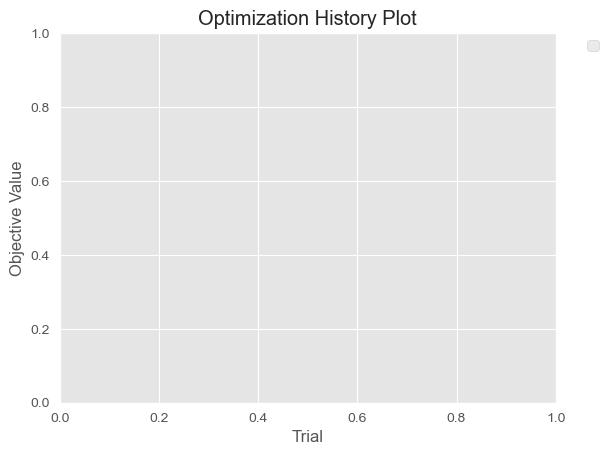

In [23]:
plot_optimization_history(study=study)

In [24]:
study_df = study.trials_dataframe()
study_df.head() 

""


In [ ]:
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

### Testing accuracies on each type of data

In [10]:
# 5-fold cross validation, stratified by label and original dataset
kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True,
                        random_state = 406)

acc_scores = {data_type: [] for data_type in ['essays', 'grover', 'wiki', 'reviews']}

for data_type in ['essays', 'grover', 'wiki', 'reviews']:
    data = train[train['Original dataset'] == data_type]
    for fold, (t_index, v_index) in enumerate(kfold.split(data, data['Label + Dataset'])):
        # Get training x and labels, and validation x and labels
        tt_x = (data.iloc[t_index]).loc[:, 0:1023]
        tt_y = (data.iloc[t_index])['Label']
        vv_x = (data.iloc[v_index]).loc[:, 0:1023]
        vv_y = (data.iloc[v_index])['Label']
        print(f"Fitting fold {fold} for data type {data_type}")
        xgb = xgboost.XGBClassifier()
        xgb.fit(tt_x.values, tt_y.values.reshape(-1,1))
        print(f"Predicting fold {fold} for type {data_type}")
        pred = xgb.predict(vv_x)
        fold_acc = acc(vv_y.values.reshape(-1,1), pred)
        print(f"Accuracy: {fold_acc}")
        acc_scores[data_type] += [fold_acc]

print("Final accuracy scores for each fold:")
print(acc_scores)

Fitting fold 0 for data type essays
Predicting fold 0 for type essays
Accuracy: 0.97625
Fitting fold 1 for data type essays
Predicting fold 1 for type essays
Accuracy: 0.98125
Fitting fold 2 for data type essays
Predicting fold 2 for type essays
Accuracy: 0.984375
Fitting fold 3 for data type essays
Predicting fold 3 for type essays
Accuracy: 0.9775
Fitting fold 4 for data type essays
Predicting fold 4 for type essays
Accuracy: 0.9840625
Fitting fold 0 for data type grover
Predicting fold 0 for type grover
Accuracy: 0.520625
Fitting fold 1 for data type grover
Predicting fold 1 for type grover
Accuracy: 0.53875
Fitting fold 2 for data type grover
Predicting fold 2 for type grover
Accuracy: 0.530625
Fitting fold 3 for data type grover
Predicting fold 3 for type grover
Accuracy: 0.5334375
Fitting fold 4 for data type grover
Predicting fold 4 for type grover
Accuracy: 0.526875
Fitting fold 0 for data type wiki
Predicting fold 0 for type wiki
Accuracy: 0.646875
Fitting fold 1 for data type